In [0]:
!pip install torch torchvision

# import PyTorch

In [0]:
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.optim as optim
import numpy as np
import matplotlib

# import Matplotlib 

In [0]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# Generate Dataset
generate sin wave

In [0]:
def wave_generate(scale=20, length=1000, sample_num=100, random_shift=5, func=np.sin):
    x = np.empty((sample_num, length), 'float64')
    x[:] = np.array(range(length)) + np.random.randint(-1 * random_shift, random_shift, sample_num).reshape(
        sample_num, 1)
    data = func(x / scale)
    torch.save(data, 'data.torch')

wave_generate()

In [0]:
def load_dataset(path='data.torch', split_position=3):
    data = torch.load(path)
    train_input = torch.from_numpy(data[split_position:, :-1])
    train_target = torch.from_numpy(data[split_position:, 1:])
    test_input = torch.from_numpy(data[:split_position, :-1])
    test_target = torch.from_numpy(data[:split_position, 1:])
    return train_input, train_target, test_input, test_target

# define model

In [0]:
class NAC(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.W_hat = Parameter(torch.Tensor(output_size, input_size))
        self.M_hat = Parameter(torch.Tensor(output_size, input_size))
        self.W = Parameter(torch.tanh(self.W_hat) * torch.sigmoid(self.M_hat))

    def forward(self, input):
        return torch.matmul(input, self.W, self.bias)


class NALU(nn.Module):
    def __init__(self, input_size, output_size, epsiron=1e-5):
        super().__init__()
        self.G = Parameter(torch.Tensor(output_size, input_size))
        self.W = Parameter(torch.Tensor(output_size, input_size))
        self.nac = NAC(output_size, input_size)
        self.epsiron = epsiron

    def forward(self, input):
        nac = self.nac(input)
        G = torch.sigmoid(torch.matmul(input, self.G.t()))
        log_in = torch.log(abs(input) + self.epsiron)
        m = torch.exp(torch.matmul(log_in, self.W.t()))
        return G * nac + (1 - G) * m



class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future=0):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]

        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs



In [0]:
split_position = 3
train_input, train_target, test_input, test_target = load_dataset(split_position=split_position)
rnn = RNN()
rnn.double()
criterion = nn.MSELoss()
optimizer = optim.LBFGS(rnn.parameters(), lr=0.9)


In [0]:
def train_model():
    def closure():
        optimizer.zero_grad()
        out = rnn(train_input)
        loss = criterion(out, train_target)
        print('train loss:', loss.item())
        loss.backward()
        return loss

    optimizer.step(closure)

def eval_model(future=1000):
    with torch.no_grad():
        pred = rnn(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        print('test loss:', loss.item())

        x = test_input.detach().numpy()
        y = pred.detach().numpy()

        def plot_graph(x, y):
            plt.figure(figsize=(25, 5))
            plt.plot(np.arange(x.shape[0]), x, 'r:')
            plt.plot(np.arange(y.shape[0]), y, 'b:')
            plt.show()
            plt.close()

        for i in range(split_position):
            plot_graph(x[i], y[i])


Epoch:  0
train loss: 0.5182855186432797
train loss: 0.509505614729228
train loss: 0.48780219702037125
train loss: 0.4724620754279023
train loss: 0.39066808588014784
train loss: 9.955608197091173
train loss: 0.21910255635586917
train loss: 0.14464338308197547
train loss: 0.6305168603763439
train loss: 0.03048808575237588
train loss: 0.023507154504718162
train loss: 0.021119270647878646
train loss: 0.0208637376770641
train loss: 0.0192168109394874
train loss: 0.016912917314548807
train loss: 0.012711961920782859
train loss: 0.006059592992456842
train loss: 0.005176859224769783
train loss: 0.004146904152963657
train loss: 0.0037814025988320813
test loss: 0.0029975244632073354


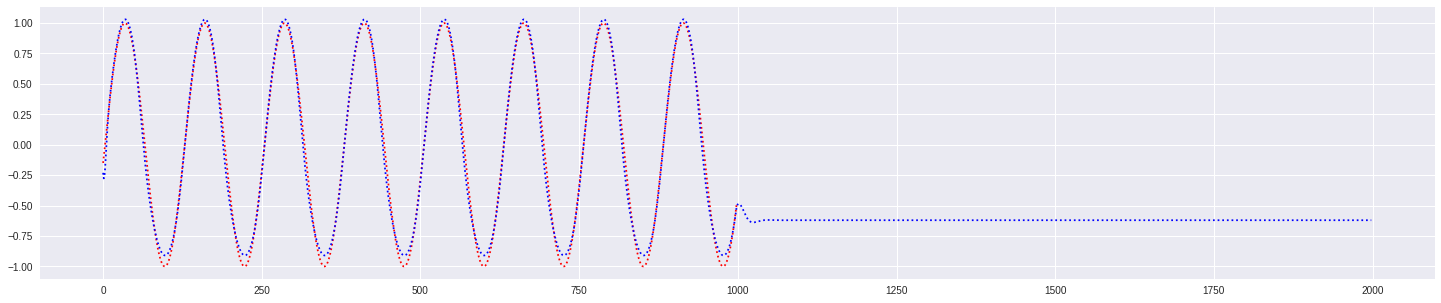

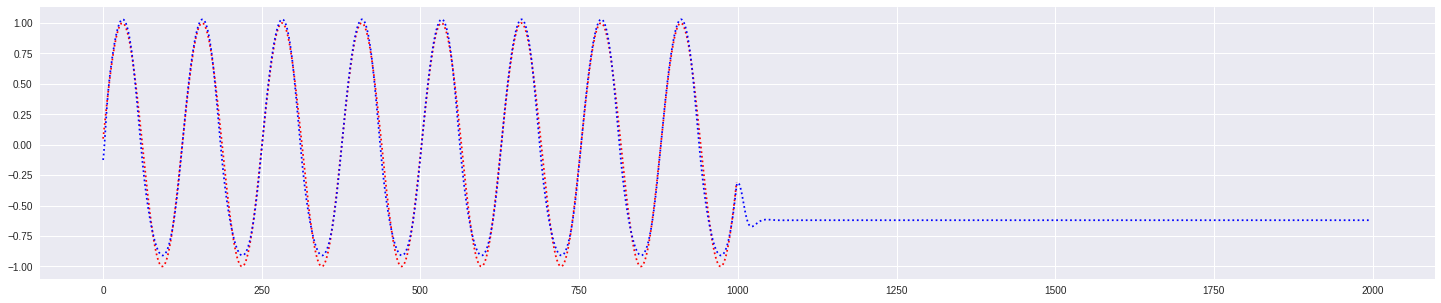

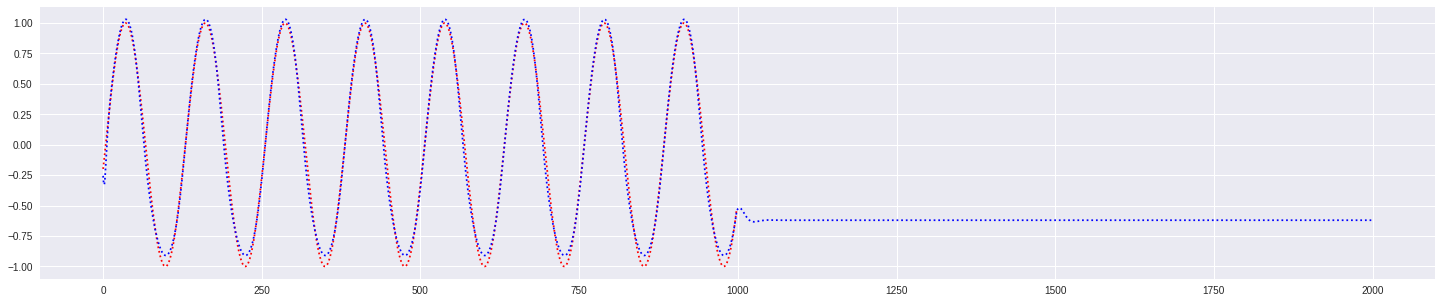

Epoch:  1
train loss: 0.002975035763050795
train loss: 0.002688058225948507
train loss: 0.002822610716068153
train loss: 0.0010856674103360286
train loss: 0.0008035847223707542
train loss: 0.0007252698858653277
train loss: 0.0006978390884752466
train loss: 0.0006642061713100454
train loss: 0.0005765087629751558
train loss: 0.00045469038182732854
train loss: 0.00034866329054092257
train loss: 0.0002750346614419183
train loss: 0.0002508278027720434
train loss: 0.00020317189946511224
train loss: 0.0001792099308186853
train loss: 0.0001539908584525978
train loss: 0.00013651542922084648
train loss: 0.0001246428027863304
train loss: 0.00012035550540901779
train loss: 0.00011594722966103686
test loss: 0.00011743937737404674


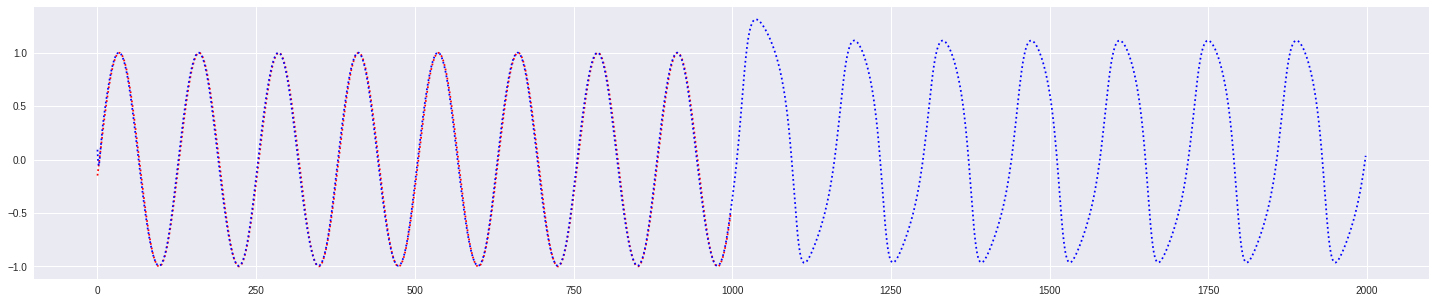

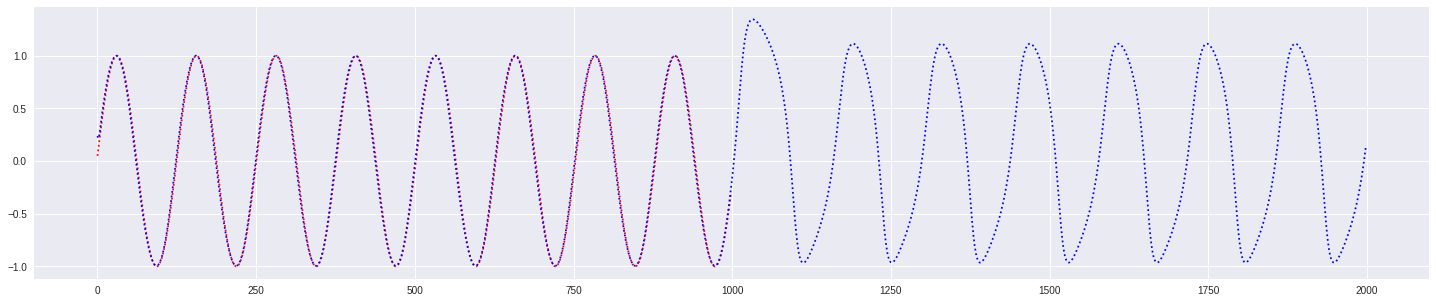

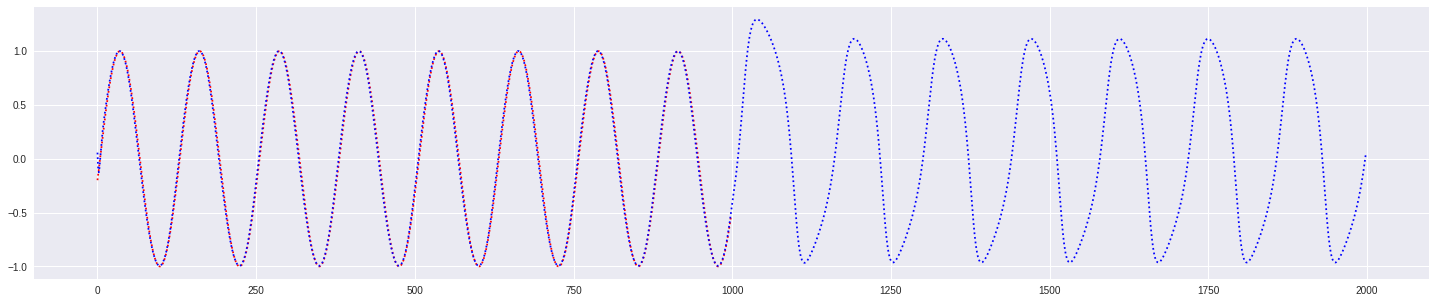

Epoch:  2
train loss: 0.00011262313797552579
train loss: 0.00010997027661417858
train loss: 0.00010794882661075005
train loss: 0.00010657165328115371
train loss: 0.00010342487226983041
train loss: 8.26707924194524e-05
train loss: 6.517936058271635e-05
train loss: 5.4109730100887746e-05
train loss: 5.5480724462639744e-05
train loss: 5.0486183843446886e-05
train loss: 4.9986391776392224e-05
train loss: 4.990862601267389e-05
train loss: 4.965601044311988e-05
train loss: 4.921645458765542e-05
train loss: 4.629138821469149e-05
train loss: 3.879022145296539e-05
train loss: 3.3728805425235695e-05
train loss: 2.9925730321003172e-05
train loss: 2.6629444450914388e-05
train loss: 2.390680338908022e-05
test loss: 2.29474279548144e-05


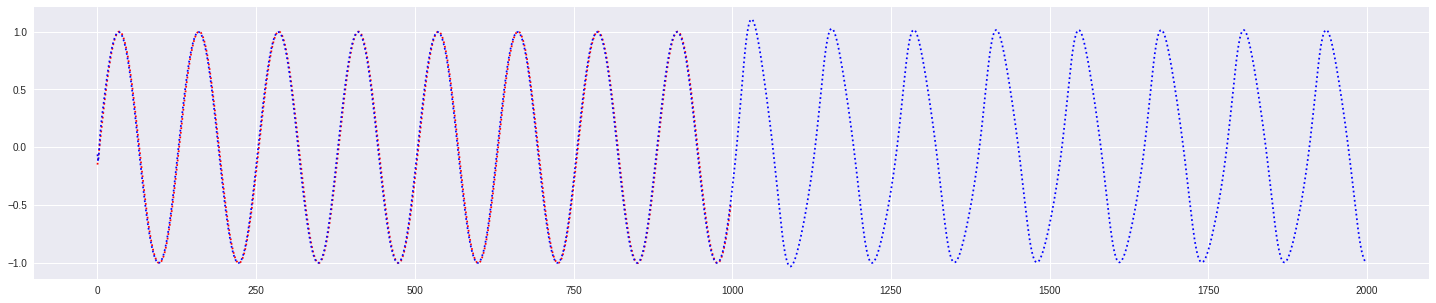

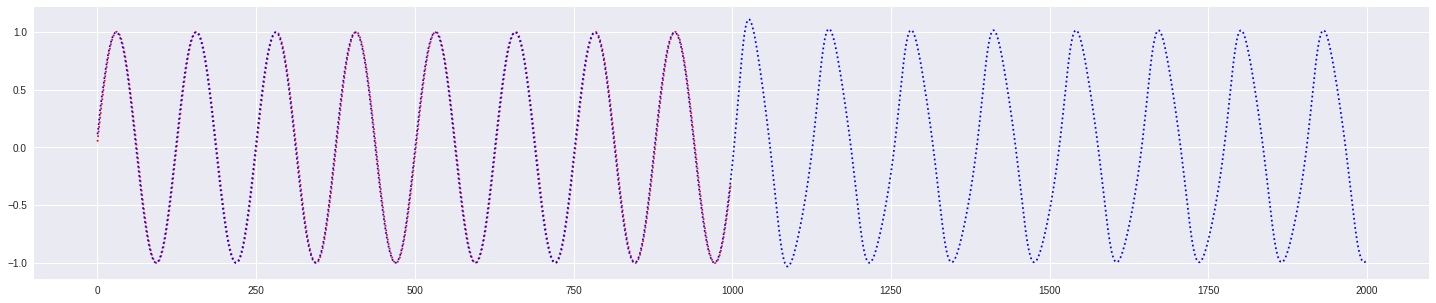

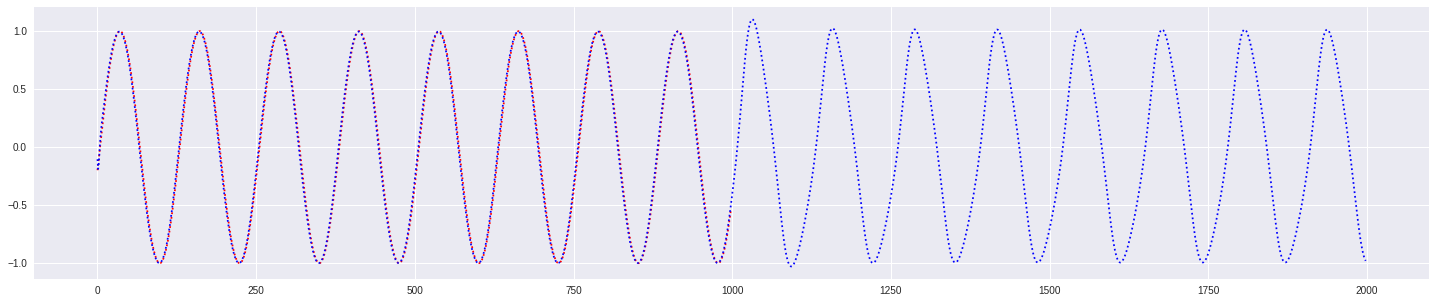

Epoch:  3
train loss: 2.1626912474358844e-05
train loss: 2.0460495386341764e-05
train loss: 1.967925030242487e-05
train loss: 1.909340445347333e-05
train loss: 1.874358897274868e-05
train loss: 1.866688316929979e-05
train loss: 1.861867205715059e-05
train loss: 1.860167149035781e-05
train loss: 1.857555606261173e-05
train loss: 1.8525218509216773e-05
train loss: 1.8467138771486318e-05
train loss: 1.839772973151677e-05
train loss: 1.8231288743895552e-05
train loss: 1.785528146001866e-05
train loss: 1.704438508983428e-05
train loss: 1.568028450927072e-05
train loss: 1.3688536634076321e-05
train loss: 1.2434616825754082e-05
train loss: 2.7355556148405985e-05
train loss: 1.1929208005339756e-05
test loss: 1.021365521319881e-05


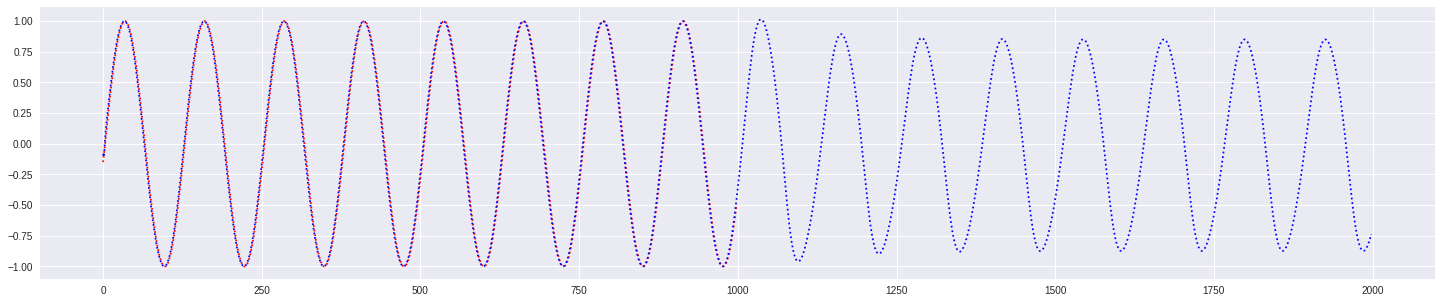

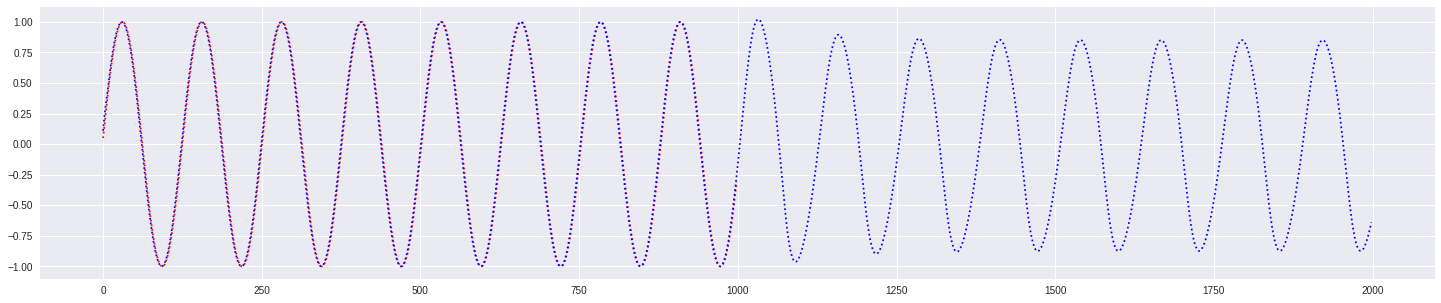

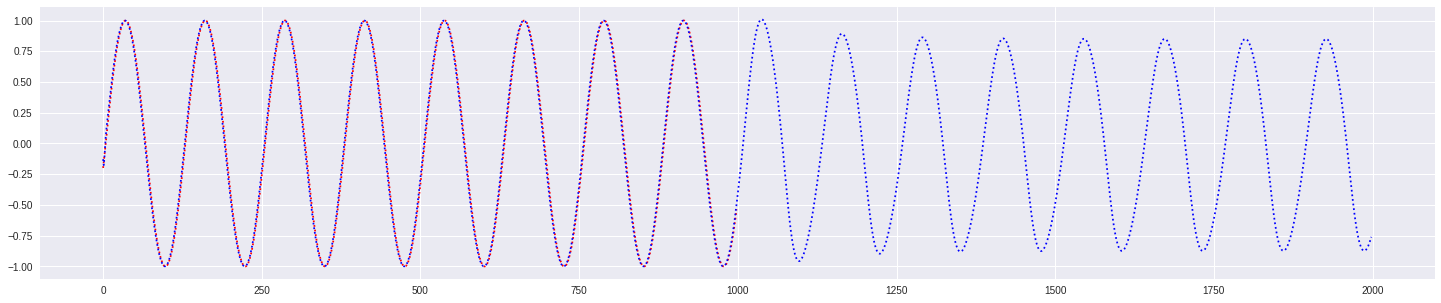

Epoch:  4
train loss: 1.1596515230044856e-05
train loss: 1.144424108084489e-05
train loss: 1.1259643268514749e-05
train loss: 1.100924236153211e-05
train loss: 1.0717911632950709e-05
train loss: 1.0436289186540894e-05
train loss: 1.0343111863769608e-05
train loss: 1.0313227389454557e-05
train loss: 1.0286235878251841e-05
train loss: 1.0266959797295423e-05
train loss: 1.0244830197497422e-05
train loss: 1.0230965727964448e-05
train loss: 1.0218689621492736e-05
train loss: 1.0200968875320324e-05
train loss: 1.0150767364778141e-05
train loss: 1.0034123865912982e-05
train loss: 9.906075607562862e-06
train loss: 9.771426236095022e-06
train loss: 9.626808534287388e-06
train loss: 9.564996302386342e-06
test loss: 7.723041147157586e-06


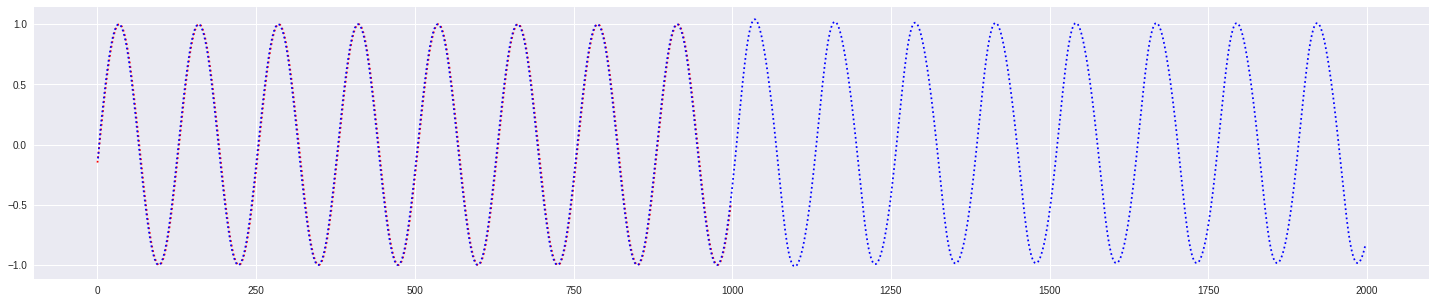

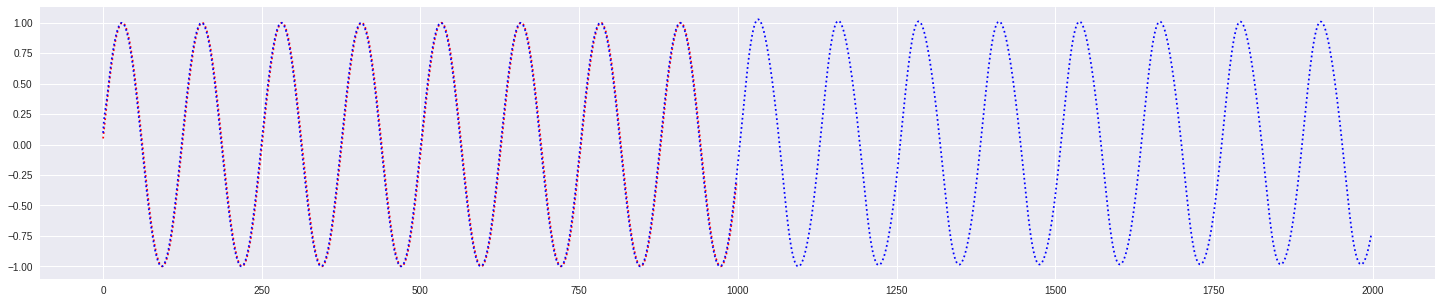

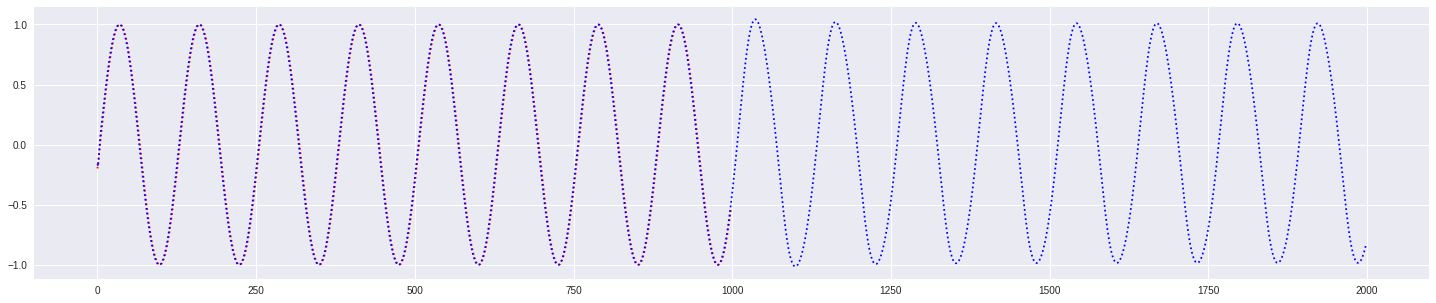

Epoch:  5
train loss: 9.32796515121485e-06
train loss: 9.210258956376978e-06
train loss: 9.166938917410698e-06
train loss: 9.15400353367414e-06
train loss: 9.143859839633691e-06
train loss: 9.136863145167943e-06
train loss: 9.132825541088968e-06
train loss: 9.12593912737e-06
train loss: 9.079555924908074e-06
train loss: 9.035672883766526e-06
train loss: 8.946534764002325e-06
train loss: 8.796956383671887e-06
train loss: 8.522187733790345e-06
train loss: 8.928174055812587e-06
train loss: 8.146186962024189e-06
train loss: 8.053515792595843e-06
train loss: 7.670079955431916e-06
train loss: 8.255009779023973e-06
train loss: 7.305964172811007e-06
train loss: 7.137377337678268e-06
test loss: 6.855710718963362e-06


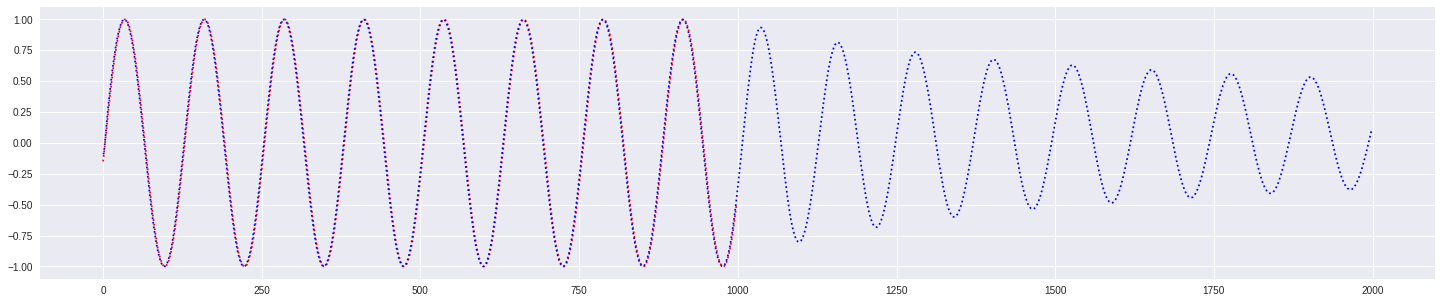

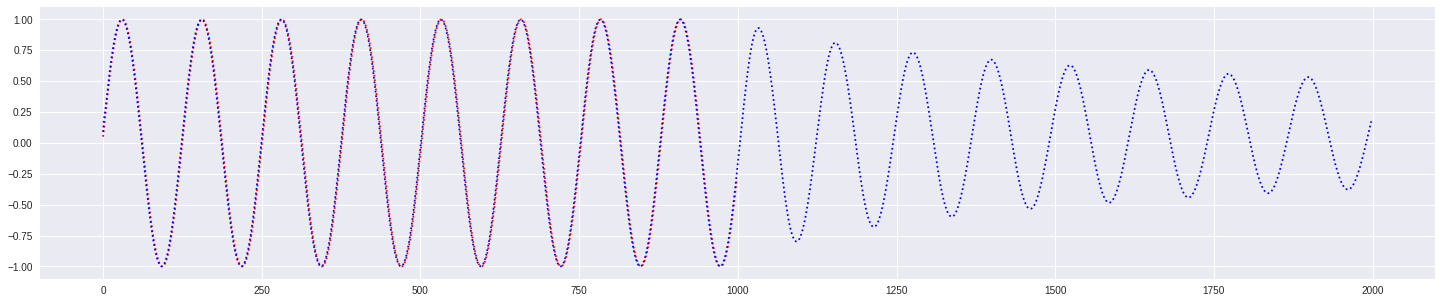

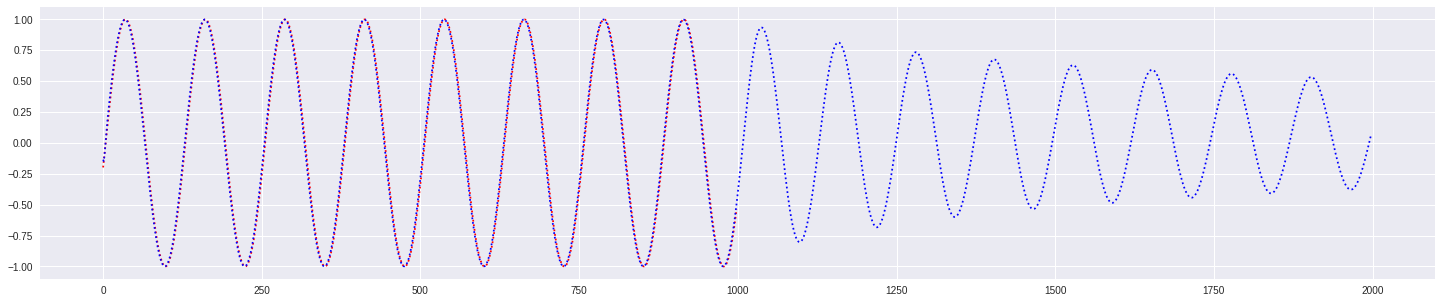

Epoch:  6
train loss: 7.151522321319239e-06
train loss: 6.614976267396494e-06
train loss: 6.545456597170765e-06
train loss: 6.288859138445102e-06
train loss: 6.433809371631745e-06
train loss: 6.046419338602772e-06
train loss: 5.854485119629389e-06
train loss: 5.3581442199854415e-06
train loss: 5.088502361965566e-06
train loss: 5.121175665013426e-06
train loss: 5.066101355328776e-06
train loss: 5.0049288667508215e-06
train loss: 5.000860211684729e-06
train loss: 4.992888334344299e-06
train loss: 4.9914079591446545e-06
train loss: 4.990202455551404e-06
train loss: 4.986156325282297e-06
train loss: 4.98337802182413e-06
train loss: 4.978777665411859e-06
train loss: 4.972504295272128e-06
test loss: 3.4745663945653077e-06


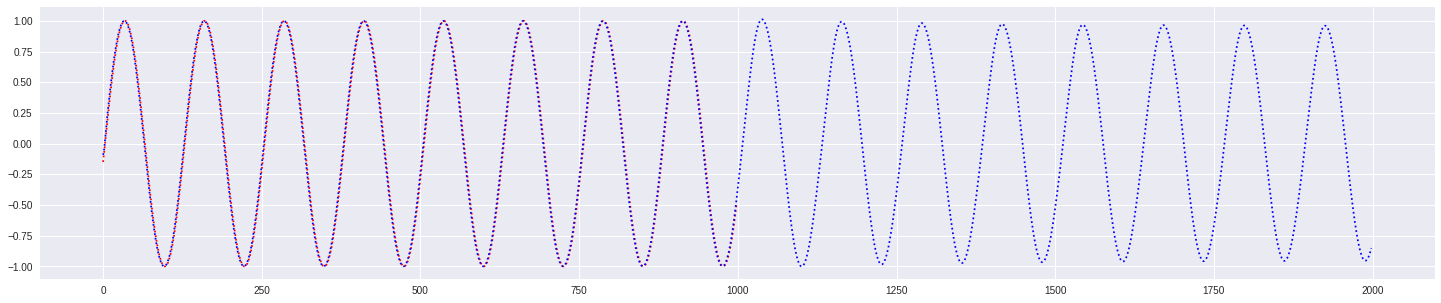

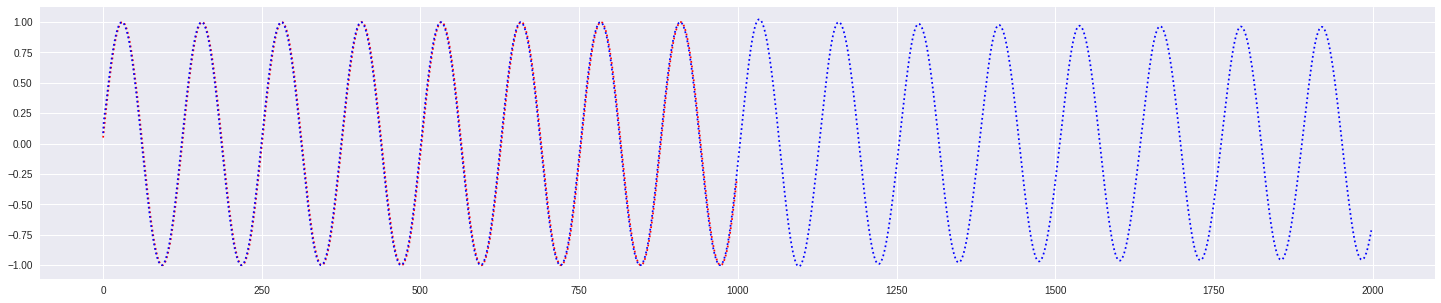

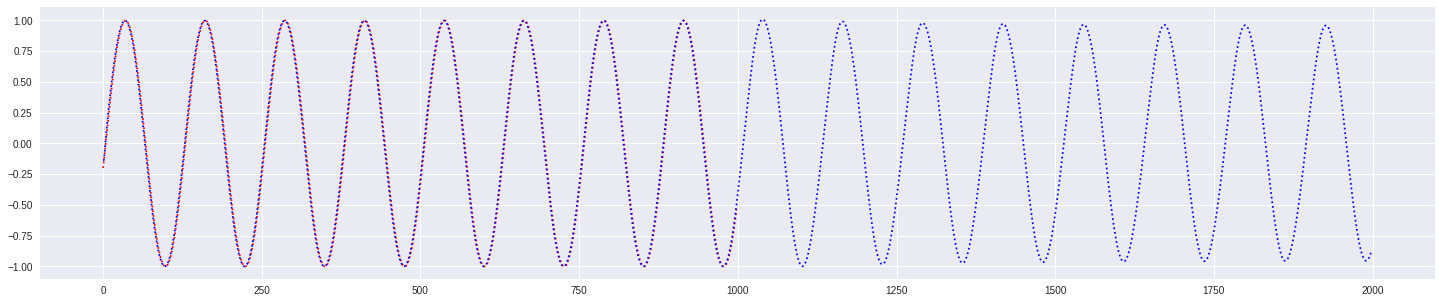

Epoch:  7
train loss: 4.963381044614891e-06
train loss: 4.950411705342998e-06
train loss: 4.929444582490344e-06
train loss: 4.9059909657435936e-06
train loss: 4.888265875867579e-06
train loss: 4.86019632160739e-06
train loss: 4.783579984413536e-06
train loss: 4.6906793296459885e-06
train loss: 4.42617623553257e-06
train loss: 4.466912810605667e-06
train loss: 4.417031630688267e-06
train loss: 4.191256223347267e-06
train loss: 4.146800594674952e-06
train loss: 3.886913877194095e-06
train loss: 4.4925047869428535e-06
train loss: 3.777471283389357e-06
train loss: 3.7417848649022015e-06
train loss: 3.6964864808414817e-06
train loss: 3.6537552846760505e-06
train loss: 3.6478159159516494e-06
test loss: 3.2545565889620217e-06


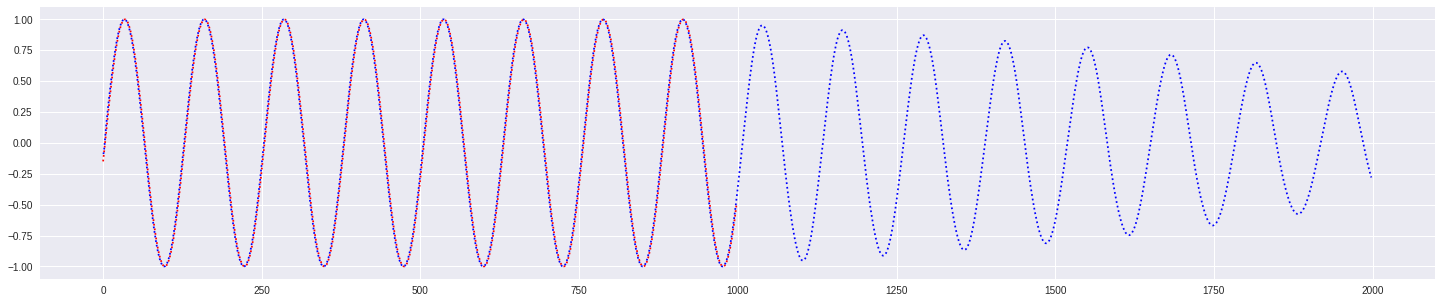

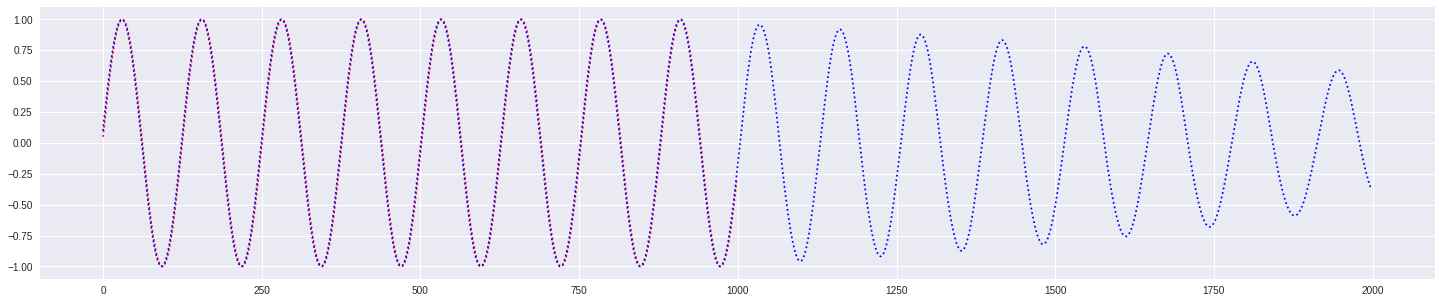

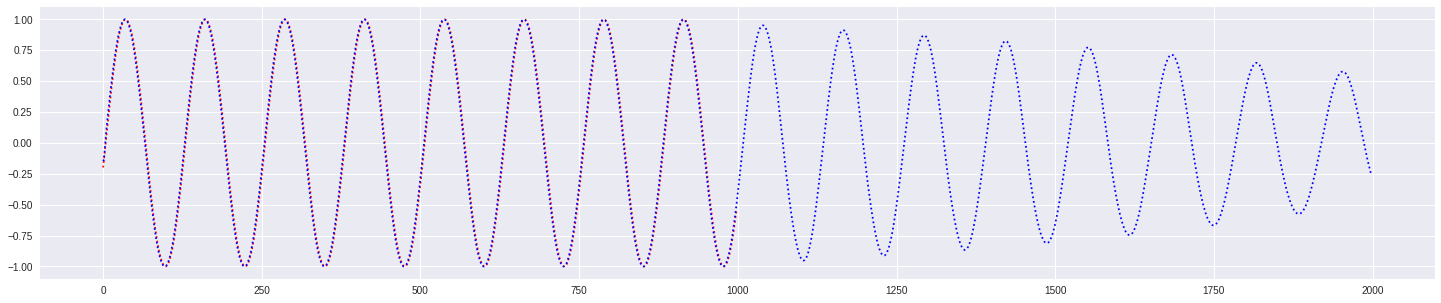

Epoch:  8
train loss: 3.64453741045268e-06
train loss: 3.6418564247964635e-06
train loss: 3.636012258179218e-06
train loss: 3.627077732862796e-06
train loss: 3.6142997834048564e-06
train loss: 3.5982270524158953e-06
train loss: 3.579193118832491e-06
train loss: 3.549745548972795e-06
train loss: 3.5354206671712063e-06
train loss: 3.5303786151949706e-06
train loss: 3.5230416207709683e-06
train loss: 3.515961191269639e-06
train loss: 3.499496578789626e-06
train loss: 3.504895513641035e-06
train loss: 3.4571467767030837e-06
train loss: 3.4346346309768163e-06
train loss: 1.554508229800257e-05
train loss: 3.3699363795953503e-06
train loss: 3.3591674618504977e-06
train loss: 3.339476553575191e-06
test loss: 2.7676470870270663e-06


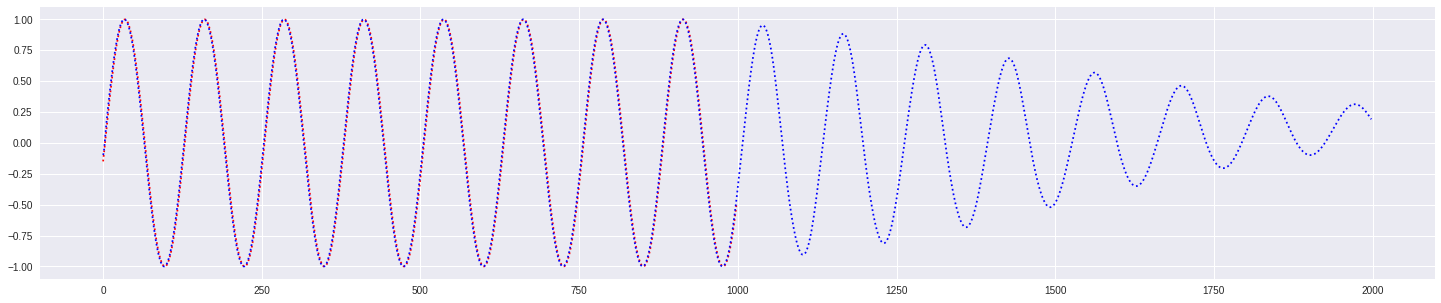

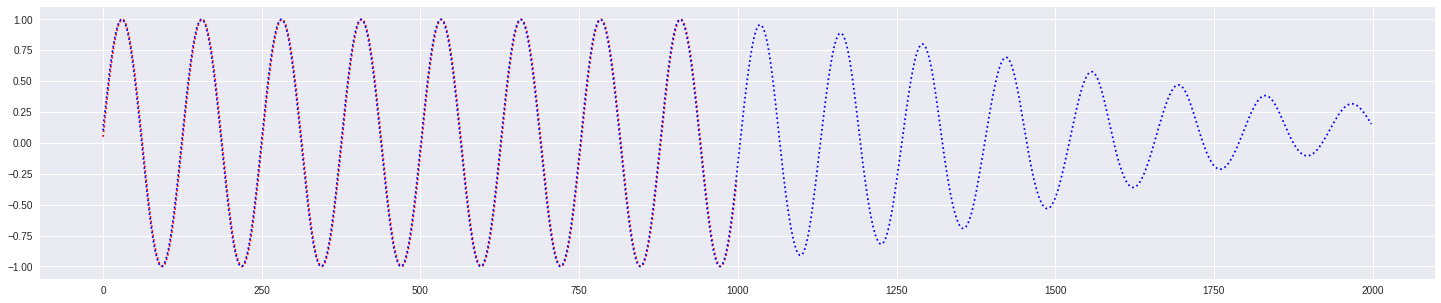

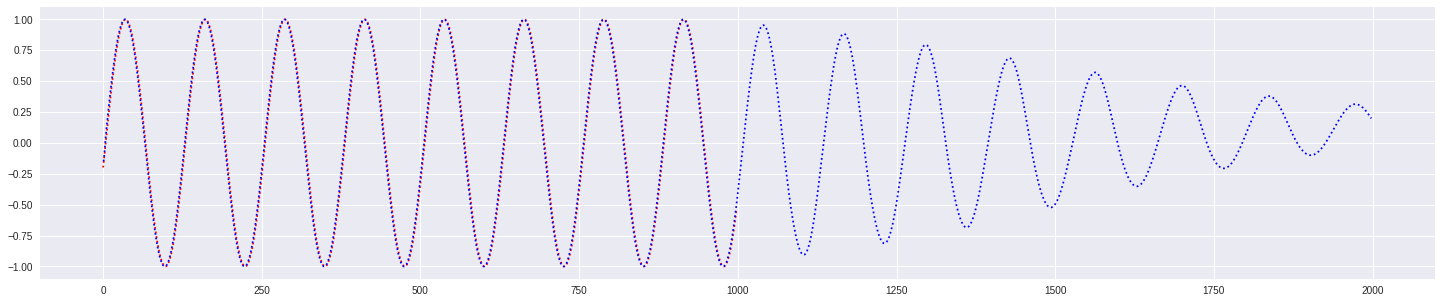

Epoch:  9
train loss: 3.3209075138446103e-06
train loss: 3.307728903226661e-06
train loss: 3.2963460112060008e-06
train loss: 3.2952722434039985e-06
train loss: 3.289862423108285e-06
train loss: 3.2867202643705655e-06
train loss: 3.282641056916535e-06
train loss: 3.277825402463338e-06
train loss: 3.2734329758848925e-06
train loss: 3.2635249230589163e-06
train loss: 3.2413841790233373e-06
train loss: 3.2148289440397636e-06
train loss: 3.1552268442958964e-06
train loss: 3.0948915217605346e-06
train loss: 3.316493903419961e-06
train loss: 3.033607042587562e-06
train loss: 3.0780947129603055e-06
train loss: 2.9579311238057198e-06
train loss: 2.9036072594354374e-06
train loss: 2.820411504960721e-06
test loss: 1.2630736129762599e-05


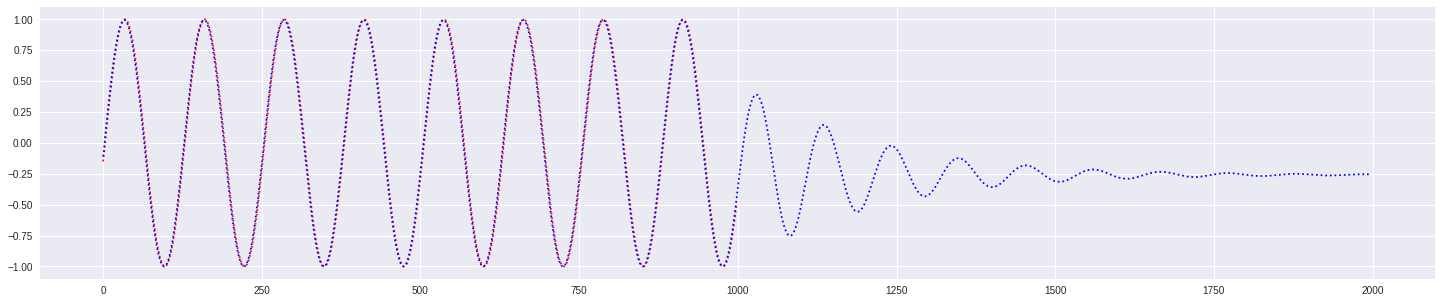

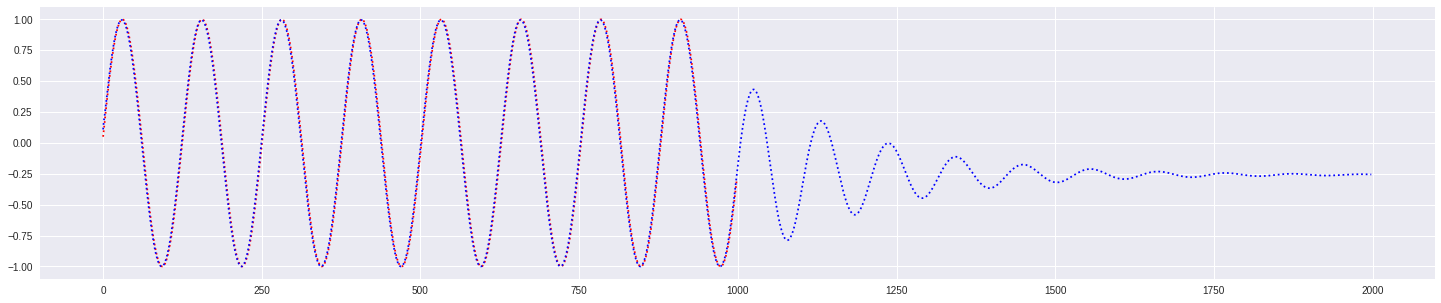

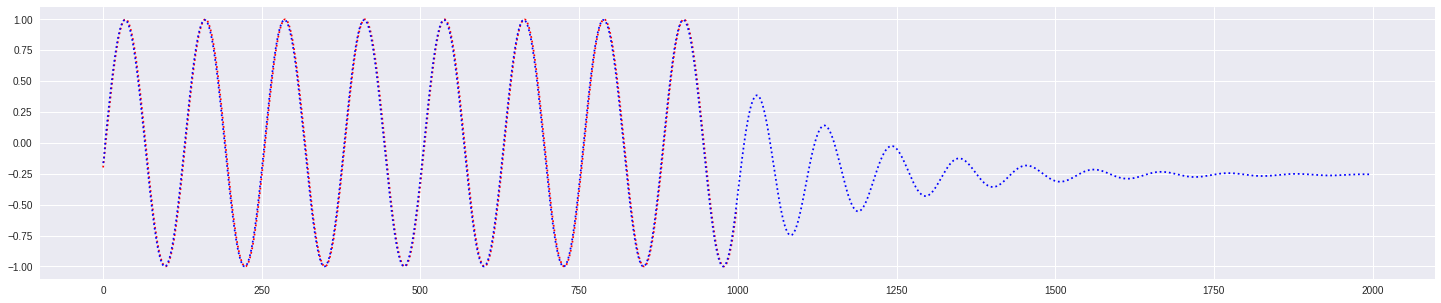

Epoch:  10
train loss: 1.297401765909064e-05
train loss: 2.716375833754819e-06
train loss: 2.6822828002867846e-06
train loss: 2.6085378702347315e-06
train loss: 2.4435629844569e-06
train loss: 2.3244356455581716e-06
train loss: 2.146421500551065e-06
train loss: 2.097309451351923e-06
train loss: 1.9827964438766548e-06
train loss: 1.950195717990467e-06
train loss: 1.8733927791480413e-06
train loss: 1.8374954761676967e-06
train loss: 1.790197901240727e-06
train loss: 1.7715612886838837e-06
train loss: 1.753779180093211e-06
train loss: 1.742037813097429e-06
train loss: 1.7283227433305964e-06
train loss: 1.72269176546013e-06
train loss: 1.7143281627054236e-06
train loss: 1.7103825850432923e-06
test loss: 1.3999585041031965e-06


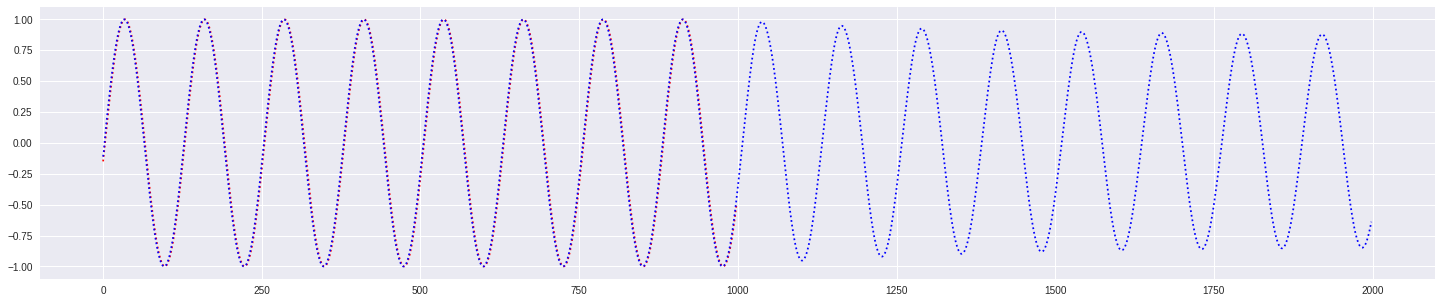

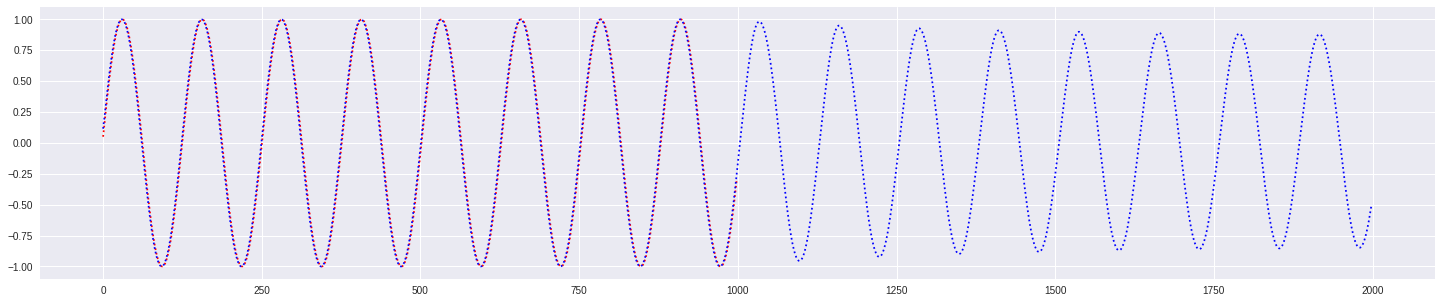

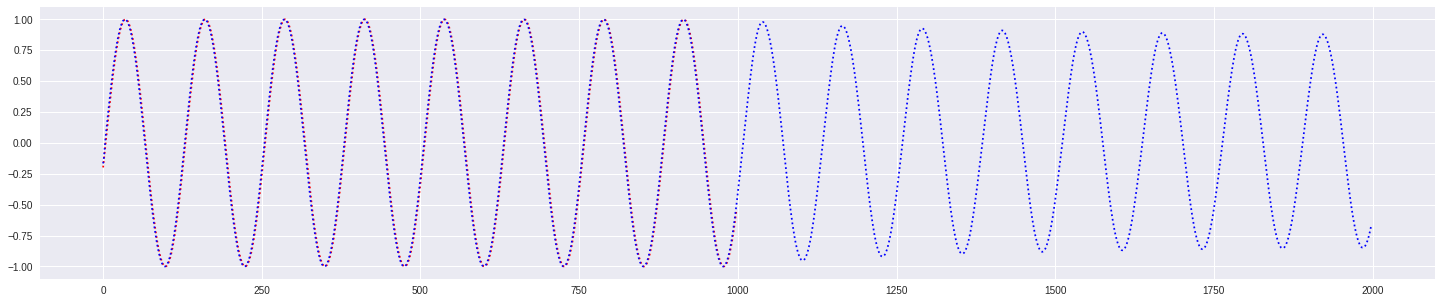

Epoch:  11
train loss: 1.7027103260916843e-06
train loss: 1.6973695433933687e-06
train loss: 1.6934034470332478e-06
train loss: 1.6873027764969466e-06
train loss: 1.6839887791761608e-06
train loss: 1.6779499945129e-06
train loss: 1.6715755536582583e-06
train loss: 1.6647786022241578e-06
train loss: 1.6501310826021466e-06
train loss: 1.6353447881625394e-06
train loss: 1.634805718950775e-06
test loss: 1.3326833410197155e-06


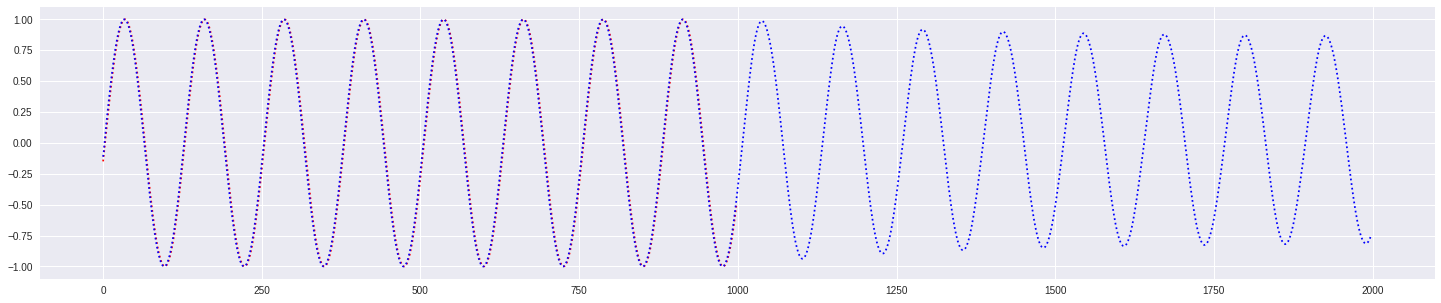

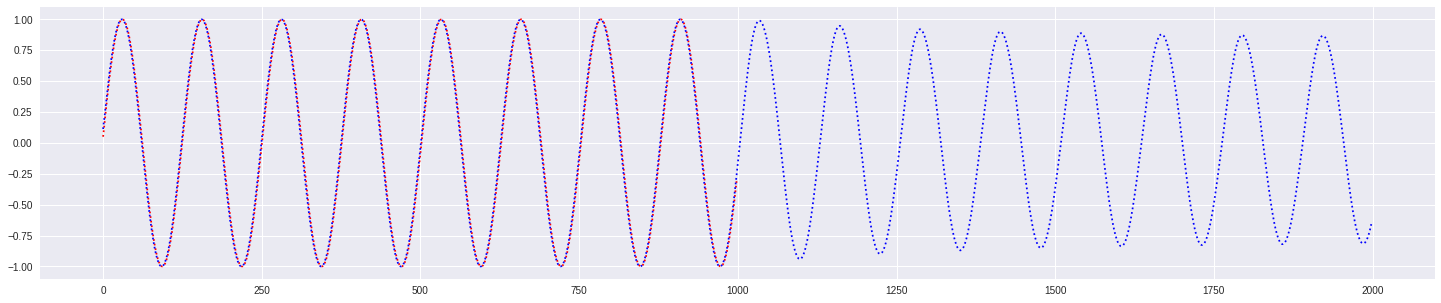

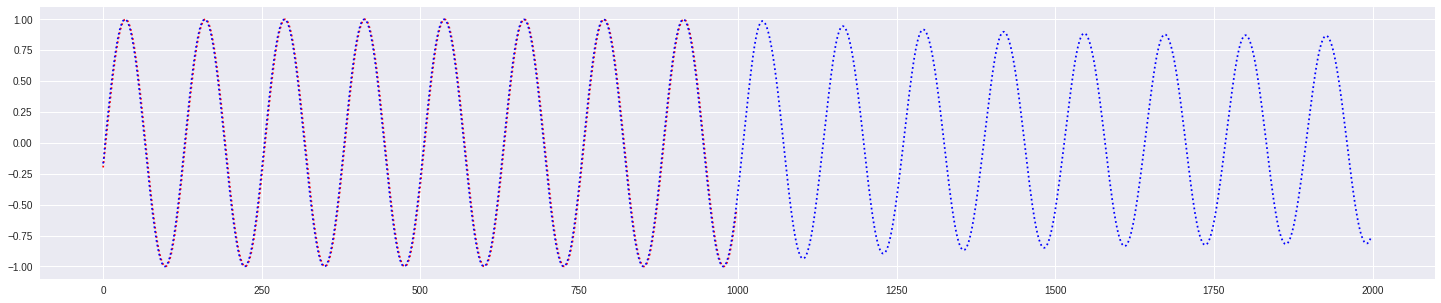

Epoch:  12
train loss: 1.634805718950775e-06
train loss: 1.6178892556680562e-06
train loss: 1.618796609354646e-06
test loss: 1.3204013852187602e-06


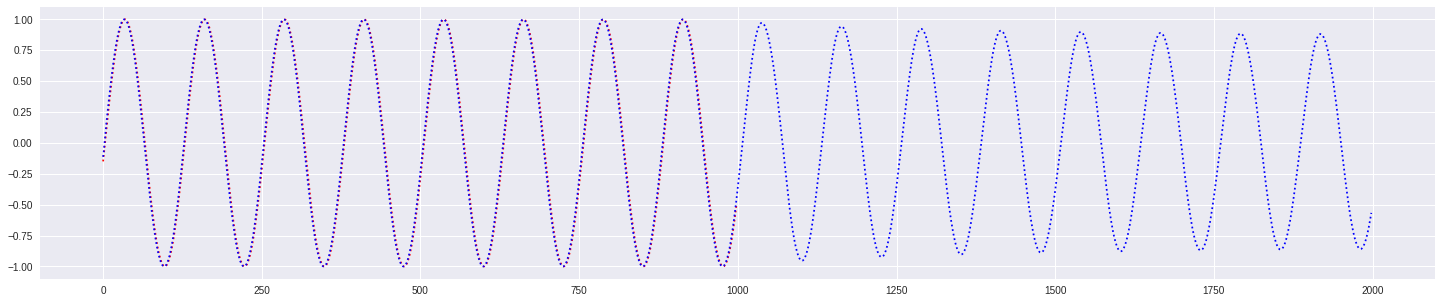

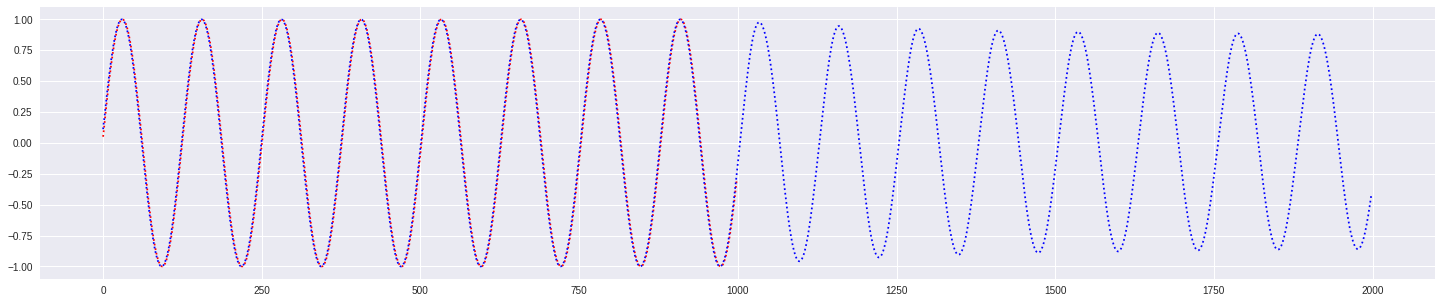

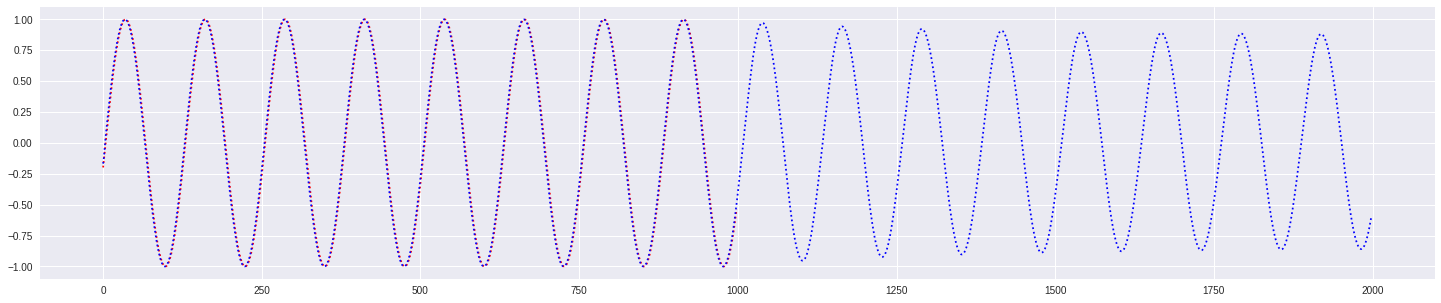

Epoch:  13
train loss: 1.618796609354646e-06
train loss: 1.6160533173676233e-06
train loss: 1.615479969340502e-06
test loss: 1.3263018057705368e-06


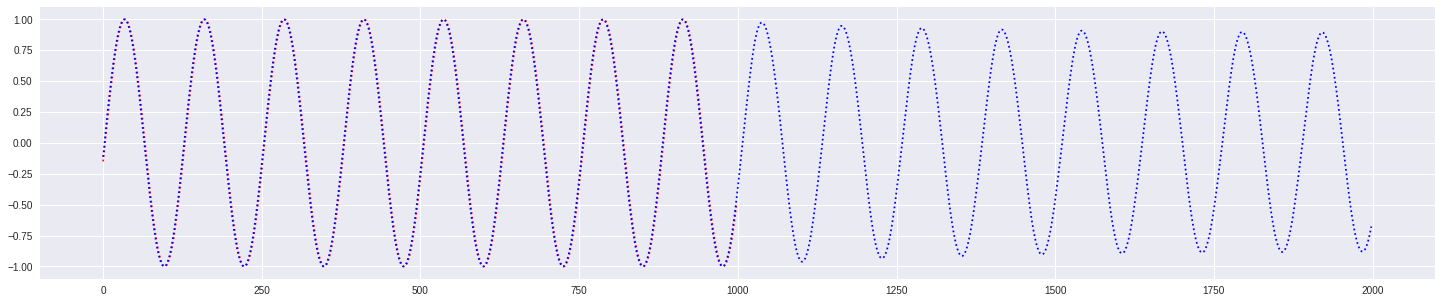

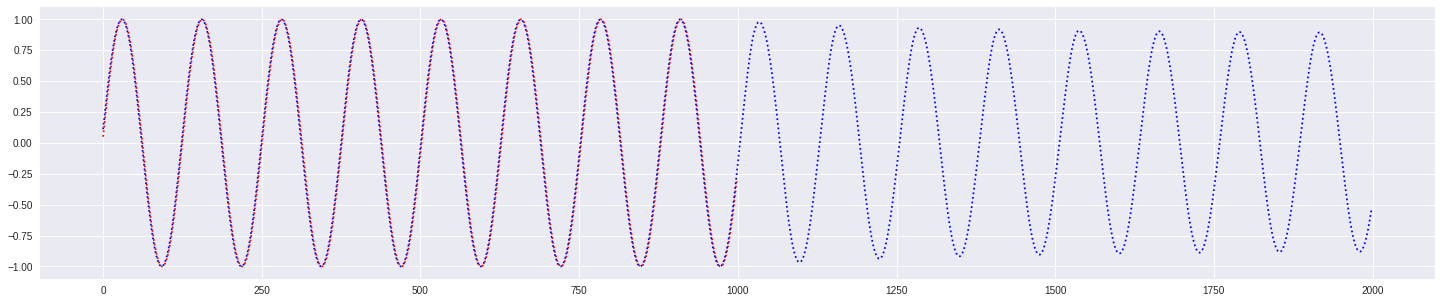

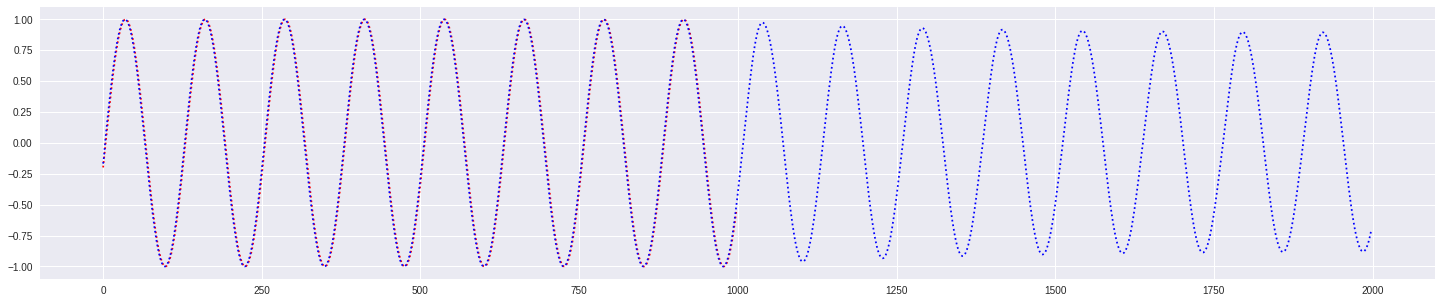

Epoch:  14
train loss: 1.615479969340502e-06
train loss: 1.6144326060004153e-06
train loss: 1.6114569339198129e-06
train loss: 1.606182891570808e-06
train loss: 1.5974264207458623e-06
train loss: 1.6127198905484532e-06
train loss: 1.5853255176562e-06
train loss: 1.5797062235742084e-06
train loss: 2.6333337141320435e-06
train loss: 1.5638374107902387e-06
train loss: 1.5575552980985838e-06
train loss: 1.5122269872504383e-06
train loss: 1.5264257362428732e-06
train loss: 1.4767956321558547e-06
train loss: 1.4608935700150997e-06
train loss: 1.4559403523780545e-06
train loss: 1.433896646580651e-06
train loss: 1.423419232811271e-06
train loss: 1.3909119988152862e-06
train loss: 1.3675692742246037e-06
test loss: 1.1600384324004376e-06


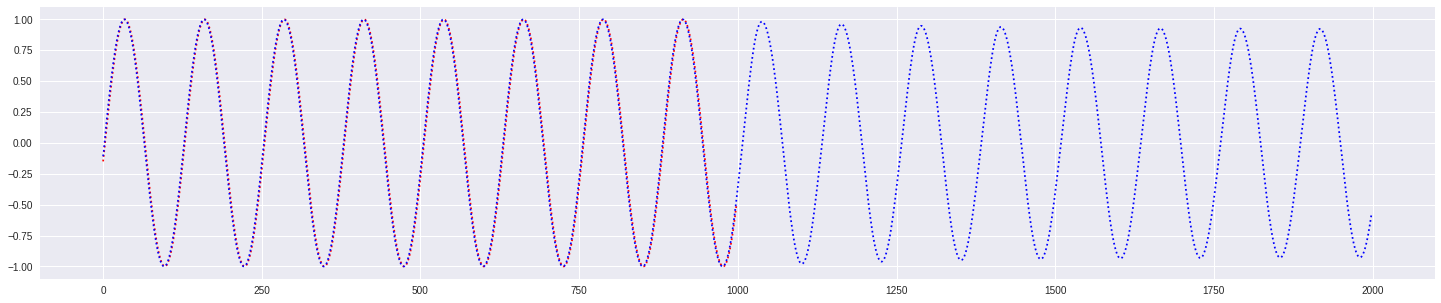

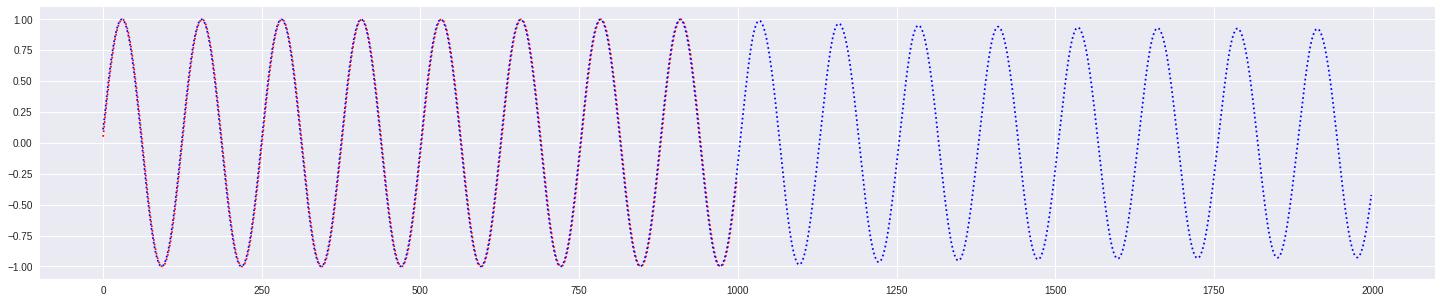

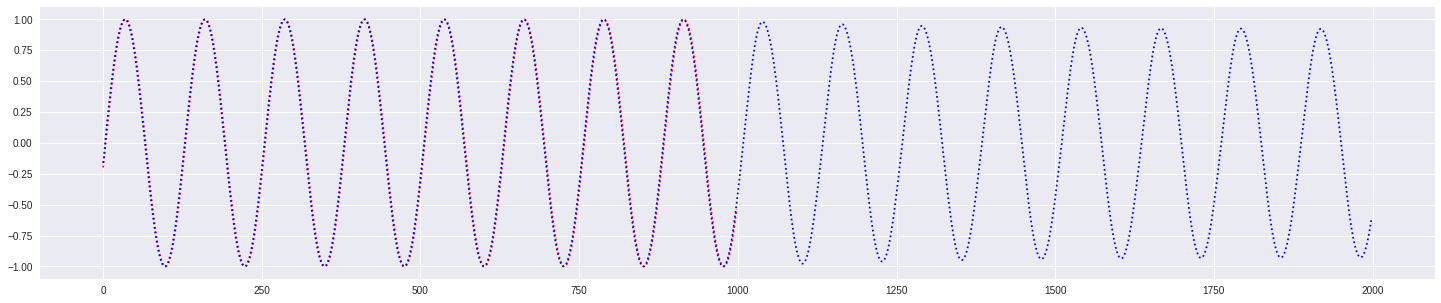

In [9]:
# begin to train
for i in range(15):
    print('Epoch: ', i)
    train_model()
    eval_model()